In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

Wczytanie danych

In [2]:
df = pd.read_csv('kaggle/Diabetes Classification.csv')

Usunięcie kolumny 'Unnamed: 0'

In [3]:
df = df.drop(columns=['Unnamed: 0'])

Sprawdź brakujące wartości

In [4]:
print(df.isnull().sum())

Age          0
Gender       0
BMI          0
Chol         0
TG           0
HDL          0
LDL          0
Cr           0
BUN          0
Diagnosis    0
dtype: int64


In [5]:
print(df.head())

   Age Gender  BMI  Chol   TG  HDL  LDL    Cr  BUN  Diagnosis
0   50      F   24   4.2  0.9  2.4  1.4  46.0  4.7          0
1   26      M   23   3.7  1.4  1.1  2.1  62.0  4.5          0
2   33      M   21   4.9  1.0  0.8  2.0  46.0  7.1          0
3   45      F   21   2.9  1.0  1.0  1.5  24.0  2.3          0
4   50      F   24   3.6  1.3  0.9  2.1  50.0  2.0          0


Konwersja kolumny 'Gender' na wartości liczbowe

In [6]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

Podstawowa eksploracja danych za pomocą paryplotu

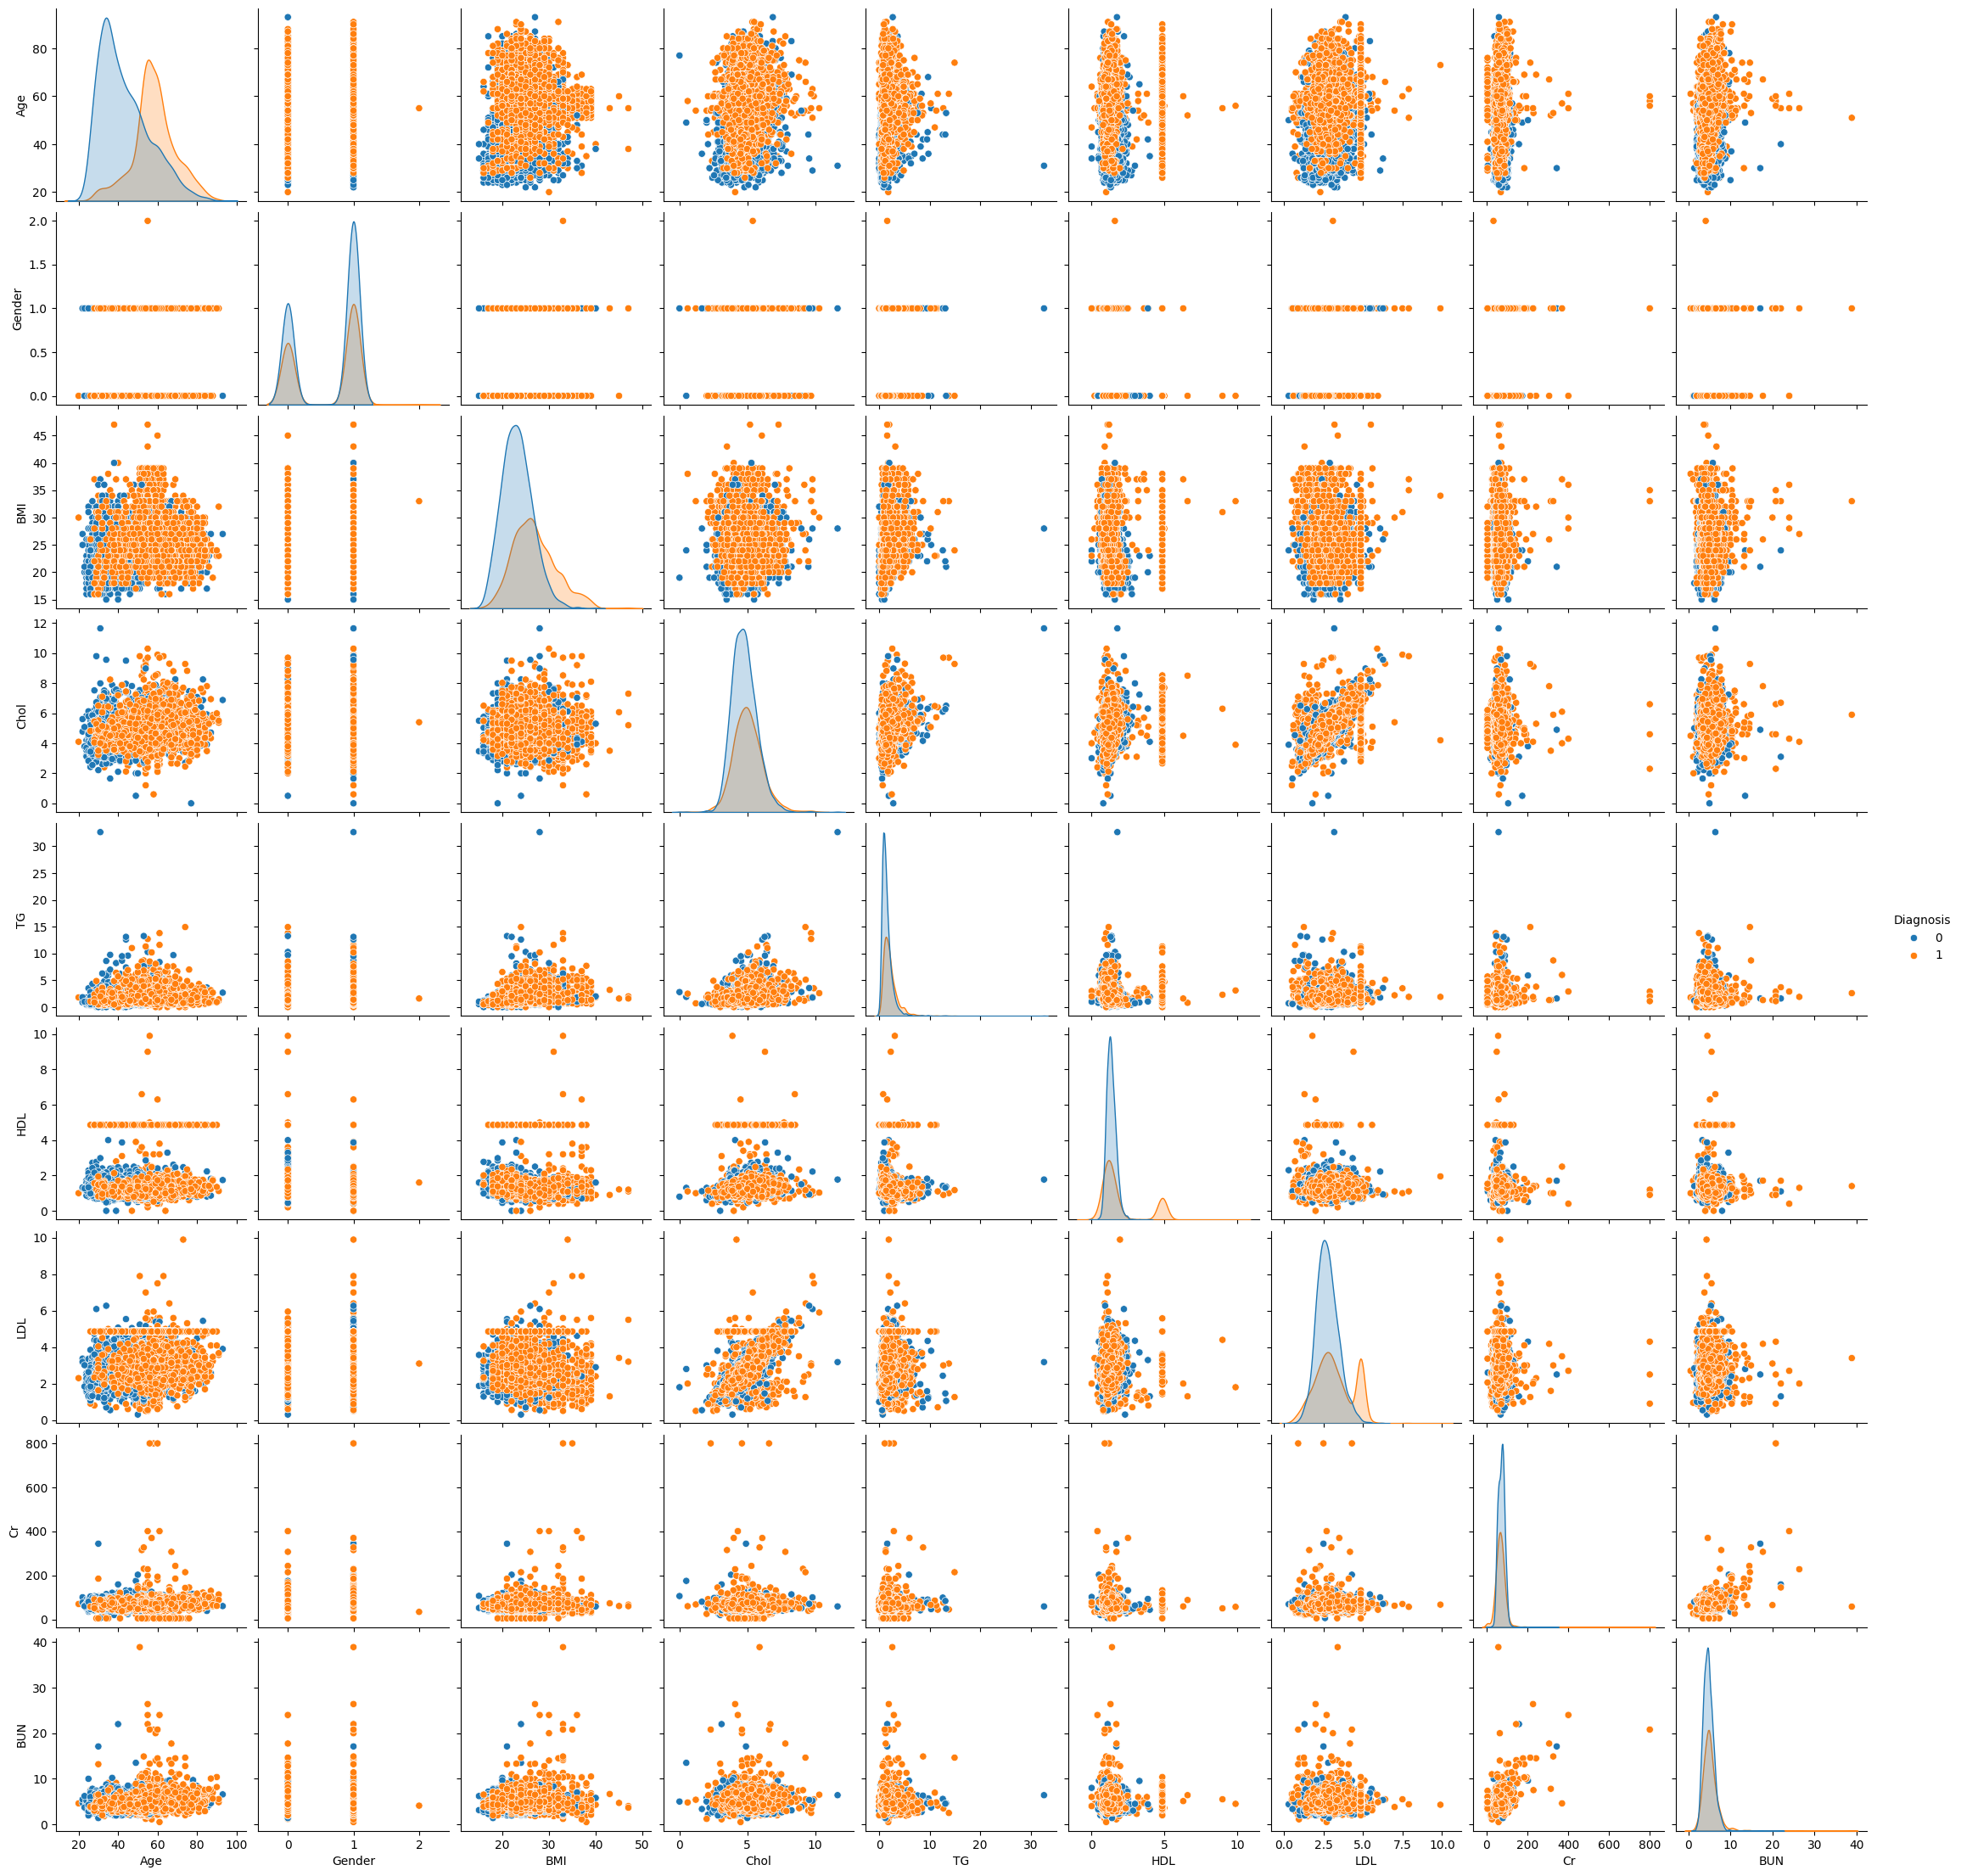

In [7]:
sns.pairplot(df, hue='Diagnosis')

plt.show()

Podział danych na cechy (X) i etykiety (y)

In [8]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

Podział danych na zbiór treningowy i testowy

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
clf = DecisionTreeClassifier(random_state=42)

Definicja parametrów do grid search

In [11]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

Inicjalizacja GridSearchCV

In [12]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

Trenowanie modelu

In [13]:
grid_search.fit(X_train, y_train)

/opt/homebrew/Cellar/jupyterlab/4.1.2/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
960 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
604 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/4.1.2/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Cellar/jupyterlab/4.1.2/libexec/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/Cellar/jupyterlab/4.1.2/libexec/lib/python3.12/site-packages/skl

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy')

Wyświetlenie najlepszych parametrów

In [14]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 20}


Przewidywanie na zbiorze testowym

In [15]:
y_pred = grid_search.best_estimator_.predict(X_test)

Ocena modelu

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.81
Confusion Matrix:
[[531  73]
 [127 296]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       604
           1       0.80      0.70      0.75       423

    accuracy                           0.81      1027
   macro avg       0.80      0.79      0.79      1027
weighted avg       0.81      0.81      0.80      1027



Ocena modelu na zestawie treningowym przy użyciu walidacji krzyżowej

In [17]:
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cross_val_scores}')

print(f'Mean cross-validation accuracy: {cross_val_scores.mean():.2f}')

Cross-validation scores: [0.82095006 0.80755177 0.78562728 0.79171742 0.81973203]
Mean cross-validation accuracy: 0.81


Wizualizacja drzewa decyzyjnego

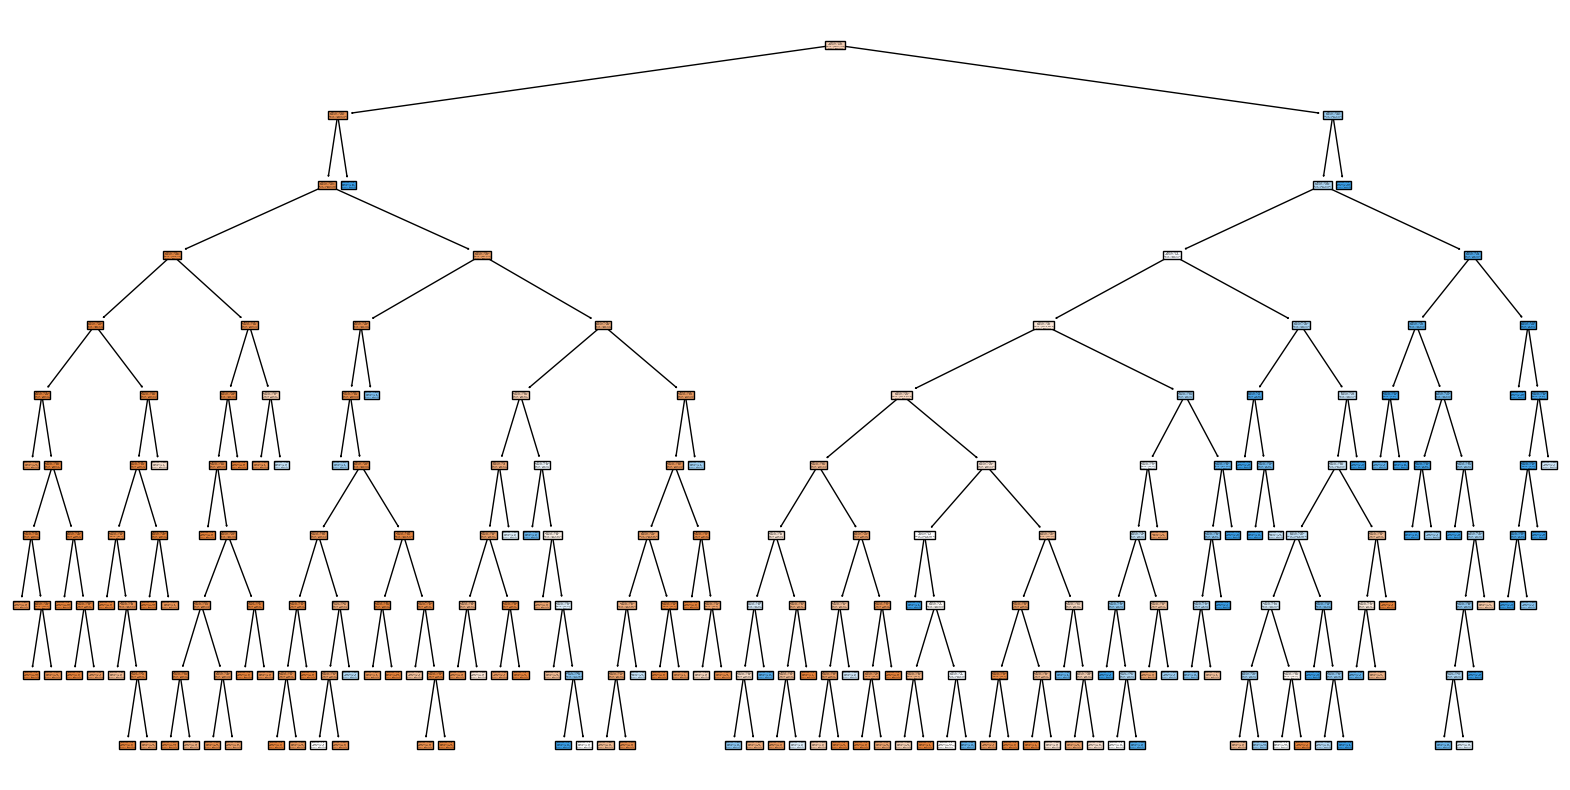

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(grid_search.best_estimator_, feature_names=X.columns, class_names=['Negative', 'Positive'], filled=True)
plt.show()

Rysowanie znaczenia cech

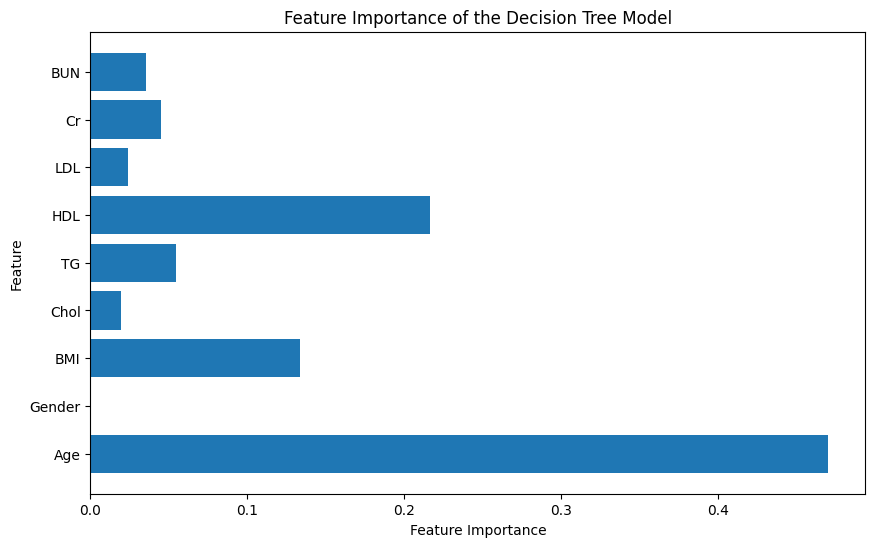

In [19]:
feature_importances = grid_search.best_estimator_.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Decision Tree Model')
plt.show()

Krzywa ROC i AUC

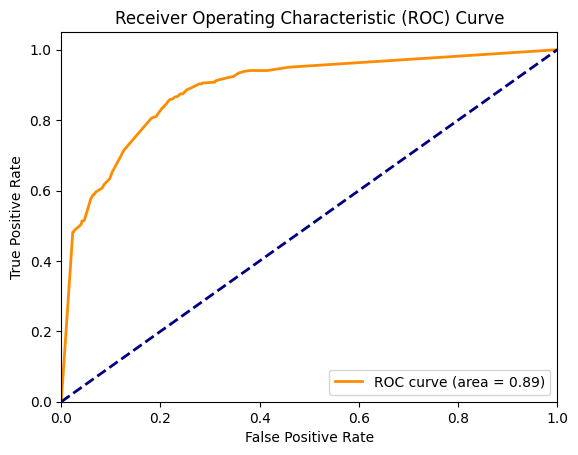

In [20]:
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Krzywa Precision-Recall

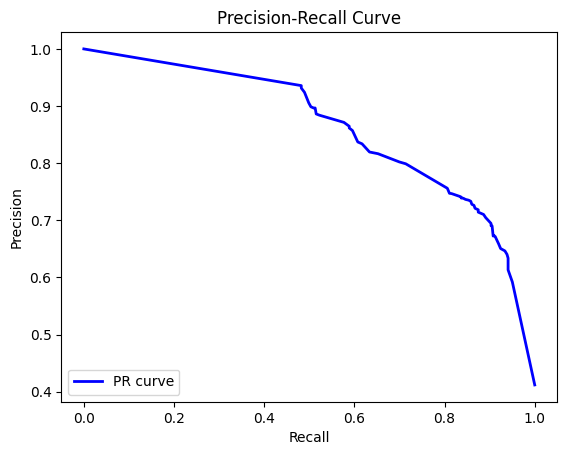

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, lw=2, color='blue', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()